In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# --------- Model: bivariate normal p(x,y) ----------
# Joint: [x, y] ~ N(mu, Sigma)
mu = np.array([0.0, 1.0])
Sigma = np.array([[1.0, 0.8],
                  [0.8, 2.0]])

# Conditional for ancestral sampling:
# x ~ N(mu_x, sigma_x^2)
# y | x ~ N(mu_y + Cov(y,x)/Var(x) * (x - mu_x), Var(y) - Cov(y,x)^2/Var(x))
mu_x, mu_y = mu
var_x = Sigma[0, 0]
var_y = Sigma[1, 1]
cov_xy = Sigma[0, 1]

beta = cov_xy / var_x
cond_var = var_y - cov_xy**2 / var_x
cond_std = np.sqrt(cond_var)

rng = np.random.default_rng(0)
n = 10000

# --------- 1) Direct joint sampling from p(x,y) ----------
xy_joint = rng.multivariate_normal(mean=mu, cov=Sigma, size=n)
df_joint = pd.DataFrame(xy_joint, columns=["x", "y"])
df_joint["scheme"] = "joint p(x,y)"

# --------- 2) Ancestral sampling from p(x) p(y|x) ----------
x = rng.normal(loc=mu_x, scale=np.sqrt(var_x), size=n)
y = rng.normal(loc=(mu_y + beta * (x - mu_x)), scale=cond_std, size=n)
df_anc = pd.DataFrame({"x": x, "y": y})
df_anc["scheme"] = "ancestral p(x)p(y|x)"

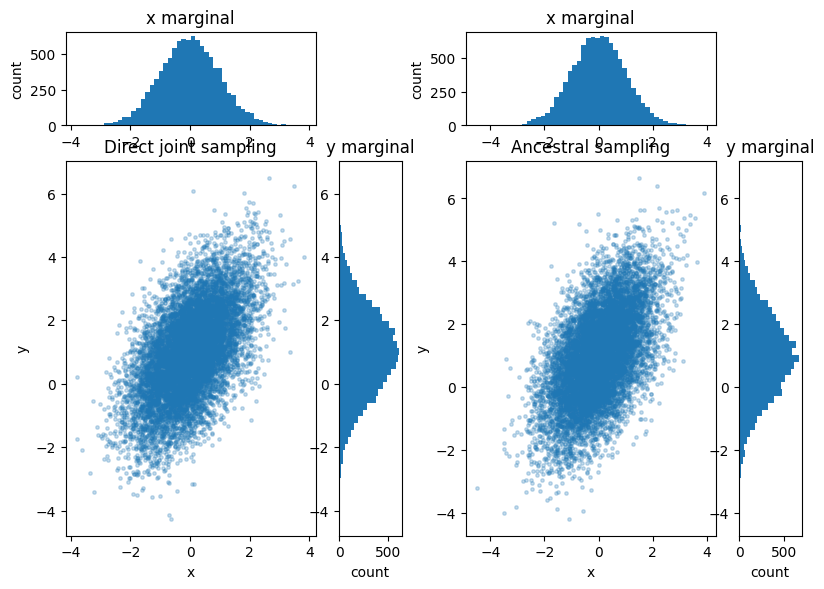

Sample means (joint):      {'x': -0.006688575096453108, 'y': 0.9938736118734638}
Sample means (ancestral):  {'x': 0.002708244318582564, 'y': 0.9986473130592305}

Sample cov (joint):
 [[0.97911124 0.78301684]
 [0.78301684 1.99336554]]

Sample cov (ancestral):
 [[0.99840688 0.77728877]
 [0.77728877 2.00883865]]


In [11]:
# --------- Pair-plot-like view (scatter + marginals) ----------
def pair_panel(ax_scatter, ax_hist_x, ax_hist_y, df, title):
    ax_scatter.scatter(df["x"], df["y"], s=6, alpha=0.25)
    ax_scatter.set_xlabel("x")
    ax_scatter.set_ylabel("y")
    ax_scatter.set_title(title)

    ax_hist_x.hist(df["x"], bins=50)
    ax_hist_x.set_ylabel("count")
    ax_hist_x.set_title("x marginal")

    ax_hist_y.hist(df["y"], bins=50, orientation="horizontal")
    ax_hist_y.set_xlabel("count")
    ax_hist_y.set_title("y marginal")

fig = plt.figure(figsize=(8, 6))

# Left: joint
gsL = fig.add_gridspec(2, 2, left=0.06, right=0.48, bottom=0.08, top=0.92,
                       width_ratios=[4, 1], height_ratios=[1, 4], wspace=0.15, hspace=0.15)
axL_histx = fig.add_subplot(gsL[0, 0])
axL_scatt = fig.add_subplot(gsL[1, 0])
axL_histy = fig.add_subplot(gsL[1, 1])
pair_panel(axL_scatt, axL_histx, axL_histy, df_joint, "Direct joint sampling")

# Right: ancestral
gsR = fig.add_gridspec(2, 2, left=0.56, right=0.98, bottom=0.08, top=0.92,
                       width_ratios=[4, 1], height_ratios=[1, 4], wspace=0.15, hspace=0.15)
axR_histx = fig.add_subplot(gsR[0, 0])
axR_scatt = fig.add_subplot(gsR[1, 0])
axR_histy = fig.add_subplot(gsR[1, 1])
pair_panel(axR_scatt, axR_histx, axR_histy, df_anc, "Ancestral sampling")

plt.show()

# Optional: sanity check that they match numerically
print("Sample means (joint):     ", df_joint[["x","y"]].mean().to_dict())
print("Sample means (ancestral): ", df_anc[["x","y"]].mean().to_dict())
print("\nSample cov (joint):\n", df_joint[["x","y"]].cov().values)
print("\nSample cov (ancestral):\n", df_anc[["x","y"]].cov().values)
